In [2]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import numpy as np
import pandas as pd

Constructing estimators 
------------------------
https://en.wikipedia.org/wiki/Autoregressive_model

#### Thomas Schmelzer

A very common estimator is based on AR models (autoregressive)

$$R_T = \sum_{i=1}^n w_i r_{T-i}$$

Predict the (unknown) return $R_T$ using the last $n$ previous returns. **Attention**: You may want to use volatility adjusted returns, apply filters etc.
 
How to pick the $n$ free parameters in $\mathbf{w}$? (Partial) autocorrelations? 



In [3]:
def convolution(ts, weights):
    from statsmodels.tsa.filters.filtertools import convolution_filter
    return convolution_filter(ts, weights, nsides=1)

In [4]:
r = pd.Series([1.0, -2.0, 1.0, 1.0, 1.5, 0.0, 2.0])
weights = [2.0, 1.0]
# trendfollowing == positive weights
x=pd.DataFrame()
x["r"] = r
x["pred"] = convolution(r, weights)
x["before"] = x["pred"].shift(1)
print(x)
print(x.corr())

     r  pred  before
0  1.0   NaN     NaN
1 -2.0  -3.0     NaN
2  1.0   0.0    -3.0
3  1.0   3.0     0.0
4  1.5   4.0     3.0
5  0.0   1.5     4.0
6  2.0   4.0     1.5
               r      pred    before
r       1.000000  0.895788 -0.190159
pred    0.895788  1.000000  0.538431
before -0.190159  0.538431  1.000000


In [5]:
# mean-reversion == negative weights
r = pd.Series([1.0, -2.0, 1.0, 1.0, 1.5, 0.0, 2.0])
weights = [-2.0, -1.0]
x=pd.DataFrame()
x["r"] = r
x["pred"] = convolution(r, weights)
x["before"] = x["pred"].shift(1)
print(x)
print(x.corr())

     r  pred  before
0  1.0   NaN     NaN
1 -2.0   3.0     NaN
2  1.0   0.0     3.0
3  1.0  -3.0     0.0
4  1.5  -4.0    -3.0
5  0.0  -1.5    -4.0
6  2.0  -4.0    -1.5
               r      pred    before
r       1.000000 -0.895788  0.190159
pred   -0.895788  1.000000  0.538431
before  0.190159  0.538431  1.000000


## Looking only at the last two returns might be a bit ...

Is it a good idea to have $n=200$ free parameters?



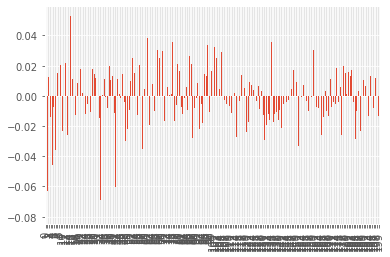

In [6]:
import statsmodels.tsa.stattools as sts
# generate random returns
r = pd.read_csv("data/SPX_Index.csv", squeeze=True, index_col=0, parse_dates=True).pct_change().dropna()
# let's compute the optimal convolution!
weights = sts.pacf(r, nlags=200)
pd.Series(data=weights[1:]).plot(kind="bar")
plt.show()

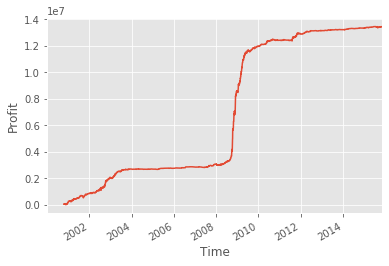

In [7]:
# The trading system! 
pos = convolution(r, weights[1:])
pos = 1e6*(pos/pos.std())
# profit = return[today] * position[yesterday]
(r*pos.shift(1)).cumsum().plot()
plt.xlabel('Time'), plt.ylabel('Profit')
plt.show()

Bias
----

We assume the weights are exponentially decaying, e.g.

$$w_i = \frac{1}{S}\lambda^i$$

where $S$ is a suitable scaling constant and $\lambda = 1-1/N$. Note that $N \neq n$.

**Everything** that is **not** an exponentially weighted moving average is **wrong**.


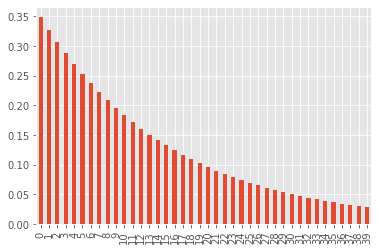

In [8]:
def exp_weights(m, n=100):
    x = np.power(1.0 - 1.0/m, range(1,n+1))
    S = np.linalg.norm(x)
    return x/S

pd.Series(exp_weights(m=16,n=40)).plot(kind="bar")
plt.show()

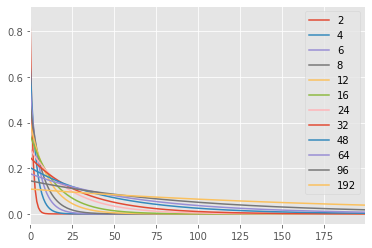

In [9]:
periods = [2,4,6,8,12,16,24,32,48,64,96,192]
# matrix of weights
W = pd.DataFrame({period : exp_weights(m=period, n=200) for period in periods}) 
W.plot()
plt.show()

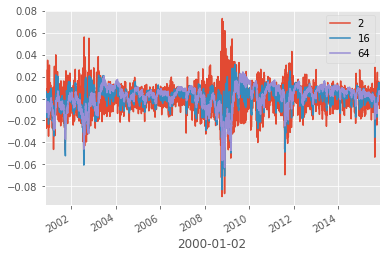

In [10]:
# each column of A is a convoluted return time series
A = pd.DataFrame({period : convolution(r, W[period]).shift(1) for period in periods})  

A = A.dropna(axis=0)
r = r[A.index].dropna()

A[[2,16,64]].plot()
plt.show()

(Naive) regression
-------------------

\begin{align}
\mathbf{w}^{*}=\arg\min_{\mathbf{w} \in \mathbb{R}^m}& \rVert{\mathbf{A}\mathbf{w} - \mathbf{r}}\lVert_2 
\end{align}

/opt/conda/envs/beakerx/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  This is separate from the ipykernel package so we can avoid doing imports until


2       -0.483518
4        8.391620
6      -57.972138
8      140.641232
12    -337.078780
16     499.437196
24    -605.732209
32     477.885878
48     -38.231327
64    -217.640728
96     167.438090
192    -36.934243
dtype: float64


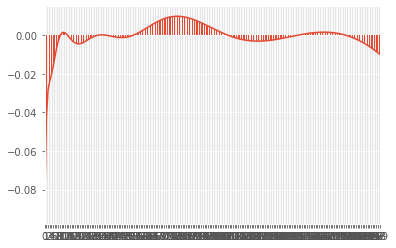

In [11]:
from numpy.linalg import lstsq
# sometimes you don't need to use MOSEK :-)
weights = pd.Series(index=periods, data=lstsq(A.values, r.values)[0])
print(weights)
(W*weights).sum(axis=1).plot(kind="bar")
(W*weights).sum(axis=1).plot()
plt.show()

### Mean variation

We provide a few indicators. Avoid fast indicators. Prefer slower indicators as they induce less trading costs.
Use the mean variation of the signal (convoluted returns here)

$$f(\mathbf{x}) = \frac{1}{n}\sum{\lvert x_i - x_{i-1}\rvert}=\frac{1}{n}\rVert{\Delta \mathbf{x}}\lVert_1$$

The $i$th column of $\mathbf{A}$ has a mean variation $d_i$. We introduce the diagonal penalty matrix $\mathbf{D}$ with $D_{i,i}=d_i$.

$$\mathbf{w}^{*}=\arg\min_{\mathbf{w} \in \mathbb{R}^m} \lVert{\mathbf{Aw}-\mathbf{r}}\rVert_2 + \lambda \rVert{\mathbf{Dw}}\lVert_1$$

In [15]:
from cvx.util import cvx, minimize

def mean_variation(ts):
    return ts.diff().abs().mean()
    
def ar(A, r, lamb=0.0):
    # introduce the variable for the var
    x = cvx.Variable(A.shape[1])  
    D = np.diag(A.apply(mean_variation))
    minimize(objective=cvx.norm(A.values*x-r,2) + lamb*cvx.norm(D*x,1))
    return pd.Series(index=A.keys(), data=x.value)

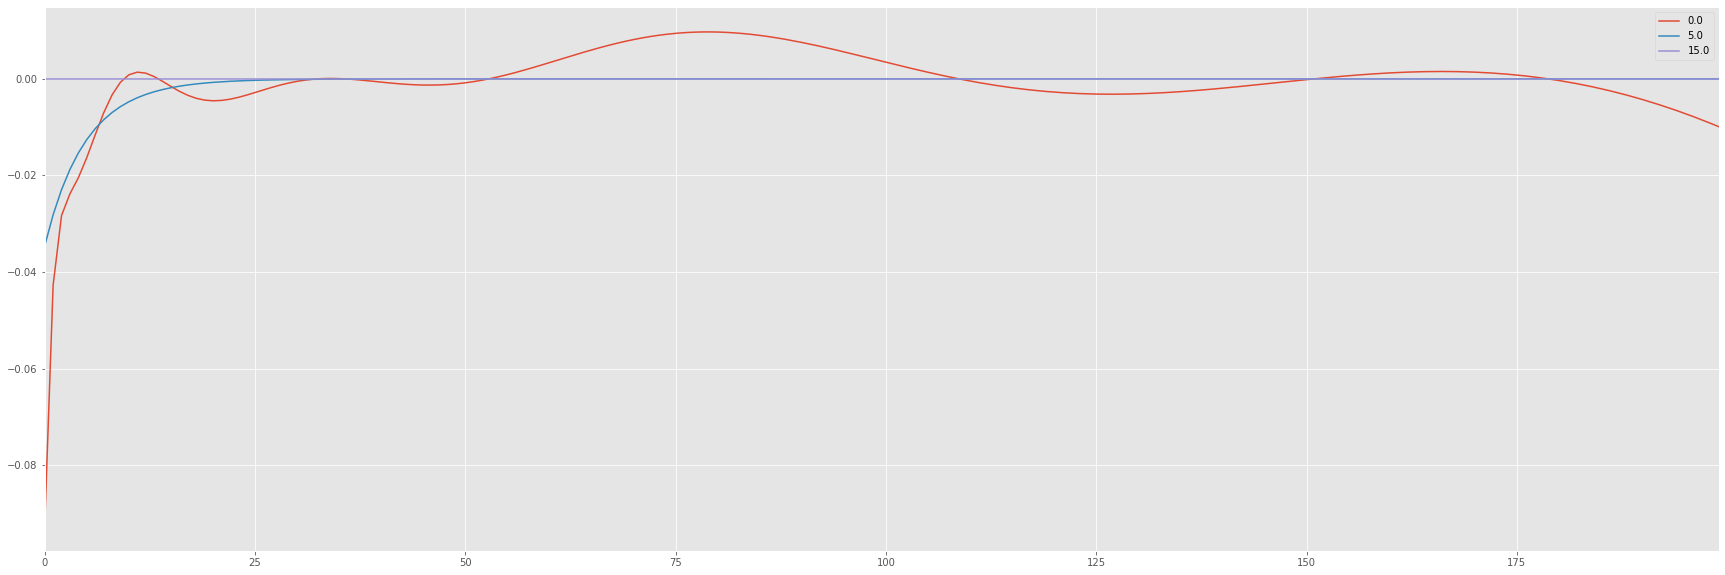

In [16]:
t_weight = pd.DataFrame({lamb : (W*ar(A, r.values, lamb=lamb)).sum(axis=1) for lamb in [0.0, 1.0, 2.0, 3.0, 5.0, 7.0, 9.0, 12.0, 15.0]})
t_weight[[0.0,5.0,15.0]].plot(figsize=(30,10))
plt.show()

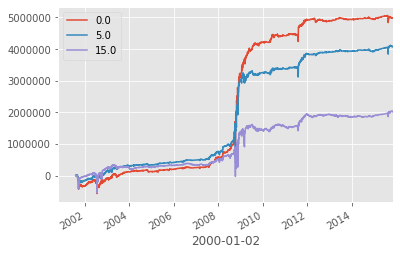

In [17]:
#for lamb in sorted(t_weight.keys()):

pos = pd.DataFrame({lamb : convolution(r, t_weight[lamb]) for lamb in t_weight.keys()})
pos = 1e6*(pos/pos.std())

profit = pd.DataFrame({lamb : (r*pos[lamb].shift(1)).cumsum() for lamb in pos.keys()})
profit[[0.0, 5.0, 15.0]].plot()
plt.show()

### Summary

- The problem of constructing an estimator is corresponds to tracking an index. The index is here a historic return time series. The **assets** are standard estimators. 


- Using the (mean) total variation of the signals can help to prefer slower signals rather than expensive fast signals.


- Using a penalty induced by the $1$-norm (see LARS, LASSO) it is possible to establish a ranking amongst the indicators and construct them robustly. 


- It is possible to (vertical) stack the resulting systems to find optimal weights across a group of assets.